In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunBayesonNorewardData import PrepareBehaviorData as PreBeh
from RunBayesonNorewardData import PreprocessData as PreD
from RunBayesonNorewardData import RunNaiveBayes_ondata as rnb

rnb = rnb()
PreD = PreD()
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions
Validation functions


## Prepare datasets

In [3]:
task_dict = {'Task1': '1 Fam Rew',
             'Task2': '2 No Rew',
             'Task3': '3 Fam Rew',
             'Task4': '4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR14/'
animalname = os.path.basename(os.path.normpath(FolderName))
frame_lick_stop = 5154
task_numframes = {'Task1': 15000, 
                  'Task2': 20000, 
                  'Task3': 20000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [6]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task2 is 134
Number of PlaceCells in Task1 is 126
Number of PlaceCells in Task4 is 126
Number of PlaceCells in Task3 is 91


### Load required Data - load actual running data

#### Control Data

In [7]:
X = A.Fc3data_dict['Task1'].T
Y = A.Parsed_Behavior['running_data'].item()['Task1']

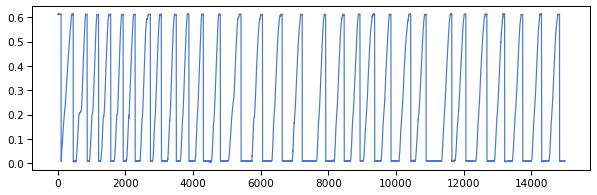

In [8]:
plt.figure(figsize = (10, 3))
plt.plot(Y)

#### No Reward Data

In [9]:
X_Norew = A.Fc3data_dict['Task2'].T
Y_Norew = A.Parsed_Behavior['running_data'].item()['Task2']

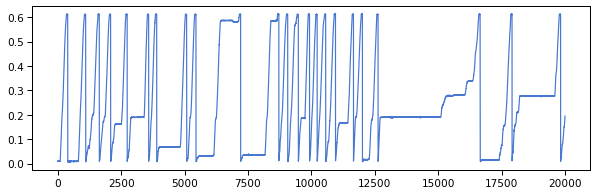

In [10]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew)

### Compare velocity of tasks and select laps with comparable speeds

Chosen speeds
Number of chosen laps : Task1 : 18, Task2 : 7
Remainin laps in 6
Task1 [10.91026469  8.65074241  7.55326017  9.55455132  8.36023241  7.94060684
  7.74693351  7.55326017  9.58683021  9.16720465  8.29567463  8.65074241
  8.29567463  8.23111685  7.81149128  7.84377017  8.94125242  7.97288573]
Task2 [ 9.48999354 10.97482247  7.81149128  8.87669464 10.49063912 10.45836023
  9.68366688]
Worst lap speeds Task2
[ 44.7062621   12.29825694  21.01355713 127.92123951  15.81665591
  59.81278244]


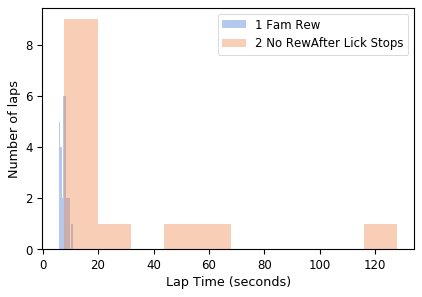

In [11]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_velocity_distribution(A, [TaskA, TaskB])
lapvelocityA, lapvelocityB, common_v_lapsA, common_v_lapsB, worst_lapsB = PreD.get_laps_of_similar_velocity(A, TaskA='Task1', TaskB='Task2', tol=0.3, after_stoplick=1)

In [12]:
# These laps dont have correct imaging data
common_v_lapsA_corrected = np.array([i for i in common_v_lapsA if i not in [0, 1]])

Data shapes :  (5130, 378) (5130, 1)
[ 3 12 13 14 15 17 19 21 22 23 24 25 26 27 28 29]
[22 17 24 13 26  3 12]
New data shapes :  (2063, 378) (2063, 1)


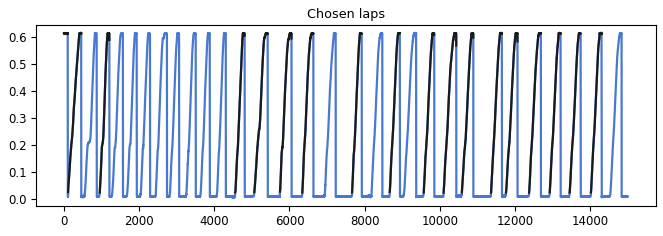

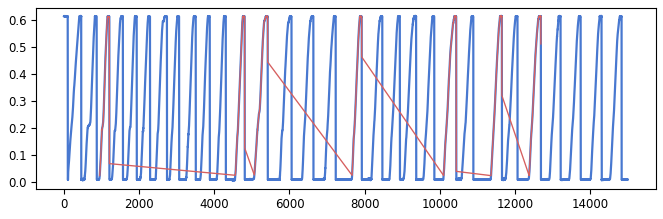

In [13]:
#Equalize laps between tasks
X_v_new, Y_v_new = PreD.compile_data_from_thresholdedlaps(A, Task=TaskA, X_data=X, Y_data=Y, thresholded_laps=common_v_lapsA, E_correction=1, figureflag=1)
X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1)

Data shapes :  (2390, 378) (2390, 1)


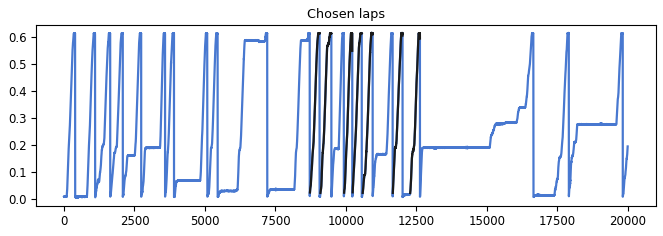

In [14]:
X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB, E_correction=1, figureflag=1)

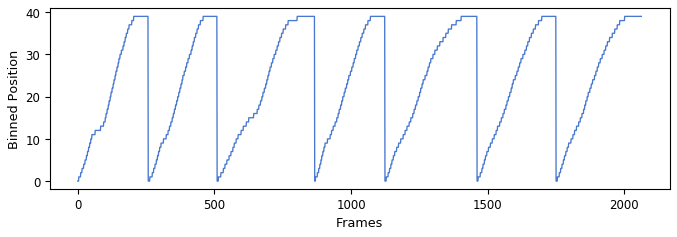

In [15]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_v_eq, tracklength=tracklength, trackbins=trackbins)
y_v_eq_cat = B.position_binary

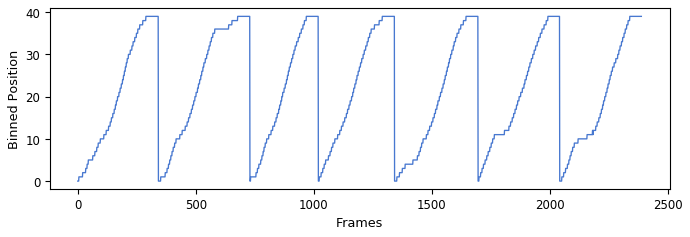

In [16]:
B = PreBeh(BehaviorData=Y_v_new_norew, tracklength=tracklength, trackbins=trackbins)
y_v_cat_norew = B.position_binary

### Run Naive Bayes on chosen lap data

#### Control data

Data shapes :  (1650, 378) (413, 378) (1650,) (413,)

Accuracy of test set:: 0.56%


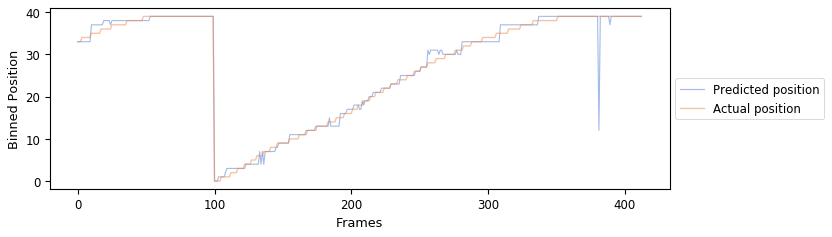

R2: 0.98
rho: 0.99




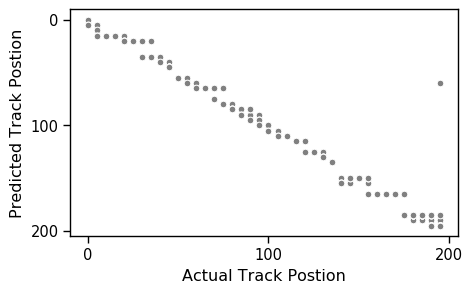

In [17]:
y_test, y_predicted = rnb.run_naivebayes(X_v_eq, y_v_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)

#### No reward Data

Data shapes :  (1912, 378) (478, 378) (1912,) (478,)

Accuracy of test set:: 0.17%


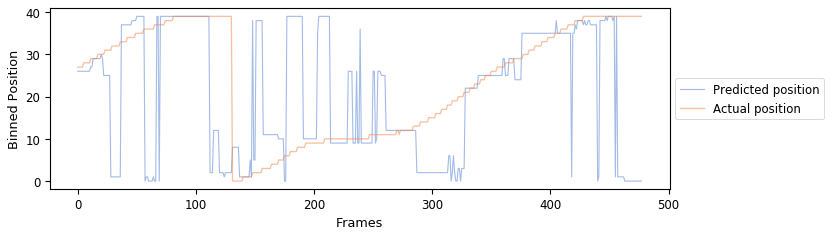

R2: -0.59
rho: 0.33




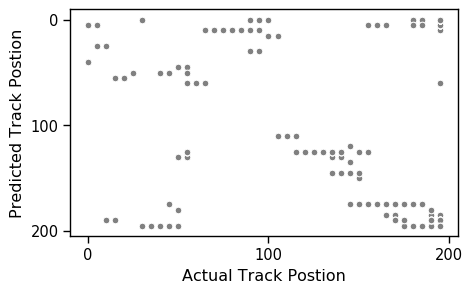

R2: -0.59
rho: 0.33




In [18]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_norew, y_v_cat_norew, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

### K-fold validation of tasks

In [19]:
nsplits = 5

#### Control Data

Performing 5-fold validation
Validation 1
(1650, 378) (1650,) (413, 378) (413,)

Accuracy of test set:: 0.28%


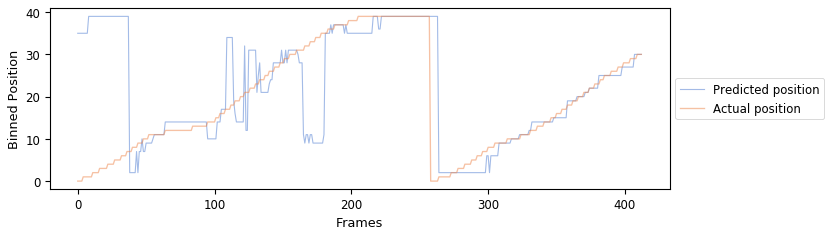

Validation 2
(1650, 378) (1650,) (413, 378) (413,)

Accuracy of test set:: 0.26%


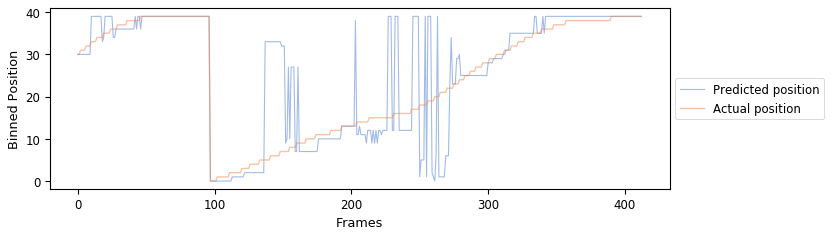

Validation 3
(1650, 378) (1650,) (413, 378) (413,)

Accuracy of test set:: 0.45%


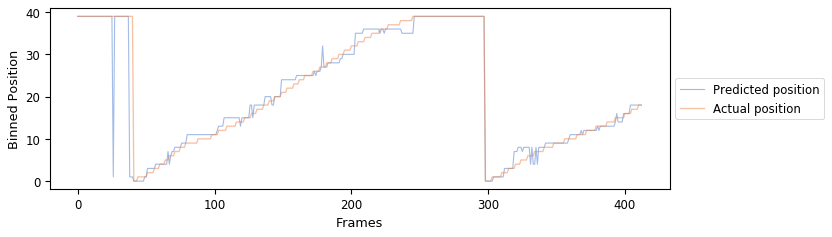

Validation 4
(1651, 378) (1651,) (412, 378) (412,)

Accuracy of test set:: 0.34%


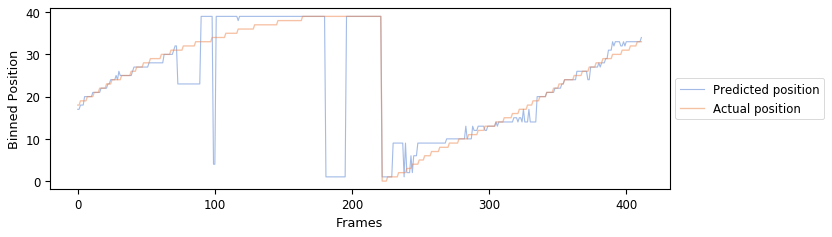

Validation 5
(1651, 378) (1651,) (412, 378) (412,)

Accuracy of test set:: 0.56%


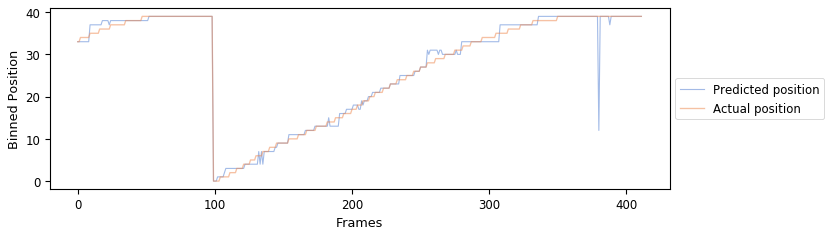

In [20]:
controlcv_dataframe = rnb.k_foldvalidation(X_data=X_v_eq, y_cat_data=y_v_eq_cat, split_size=nsplits, figureflag=1)

Performing 5-fold validation
Validation 1
(1912, 378) (1912,) (478, 378) (478,)

Accuracy of test set:: 0.32%


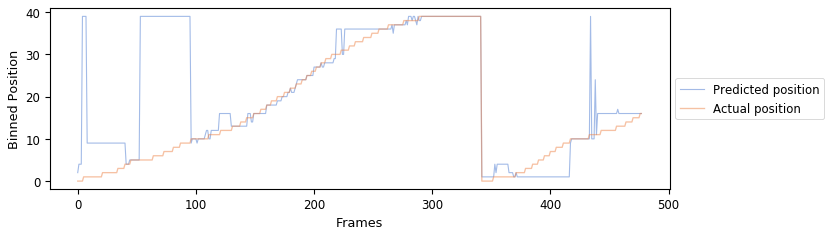

Validation 2
(1912, 378) (1912,) (478, 378) (478,)

Accuracy of test set:: 0.21%


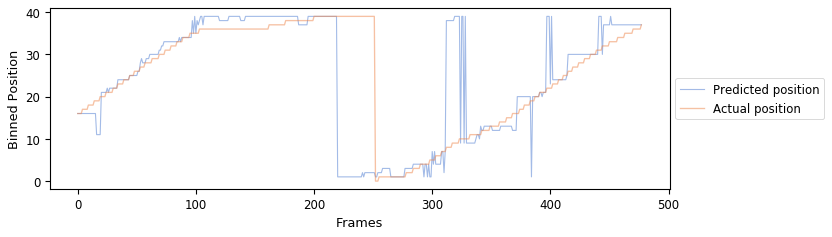

Validation 3
(1912, 378) (1912,) (478, 378) (478,)

Accuracy of test set:: 0.31%


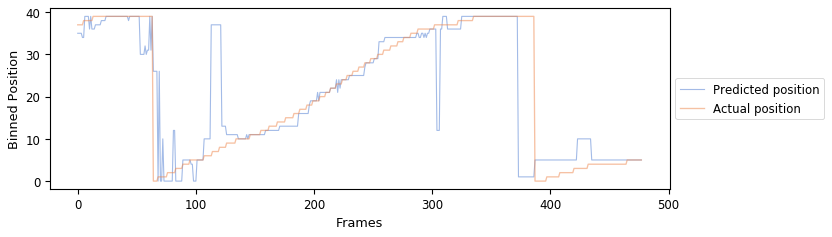

Validation 4
(1912, 378) (1912,) (478, 378) (478,)

Accuracy of test set:: 0.27%


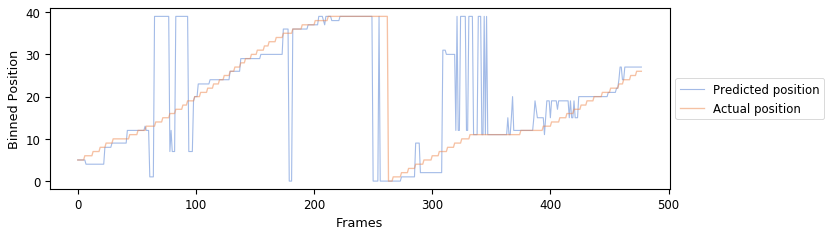

Validation 5
(1912, 378) (1912,) (478, 378) (478,)

Accuracy of test set:: 0.17%


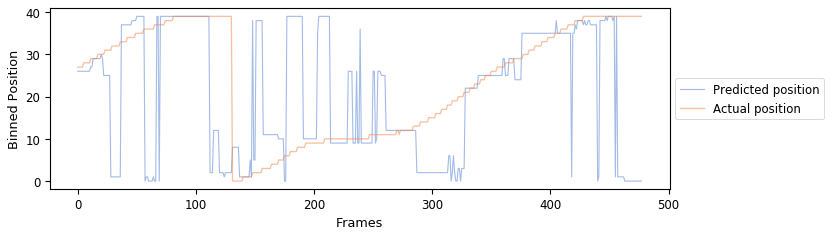

In [21]:
norewardcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_norew, y_cat_data=y_v_cat_norew, split_size=nsplits, figureflag=1)

### Compare Control with the worst but corrected laps

In [22]:
X_Norew_goodlaps = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_Norew_goodlaps = A.Parsed_Behavior['good_running_data'].item()['Task2']

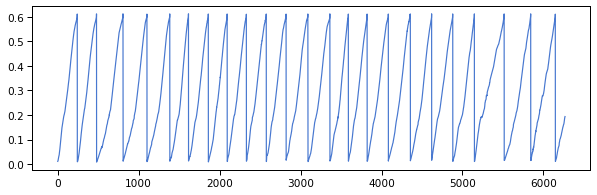

In [23]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew_goodlaps)

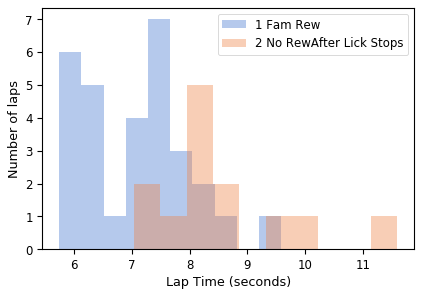

In [24]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_corrected_velocity_distribution(A, [TaskA, TaskB])

In [25]:
correctedlaptime_worstlaps = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[worst_lapsB]

Data shapes :  (1680, 378) (1680, 1)
[11 14 18 21 22 23]
[10 13 17 20 21 22]
New data shapes :  (1686, 378) (1686, 1)


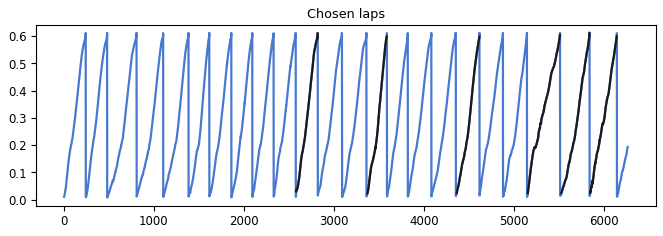

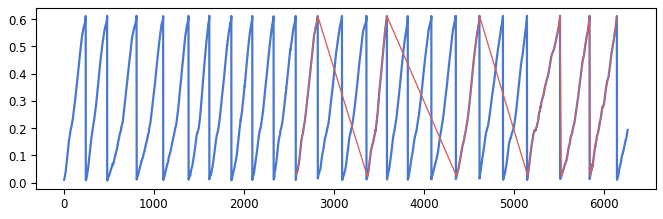

In [26]:
X_new_norew_goodlaps, Y_new_norew_goodlaps = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, 
                                              thresholded_laps=worst_lapsB, E_correction=1, 
                                              lapcorrectionflag=1, figureflag=1)
X_norew_goodlaps_eq, Y_norew_goodlaps_eq = PreD.equalise_laps_with_numlaps_innorew(A, X_Norew_goodlaps, Y_Norew_goodlaps, Tasklabel='Task2', laps_current=worst_lapsB, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1, lapcorrectionflag=1)

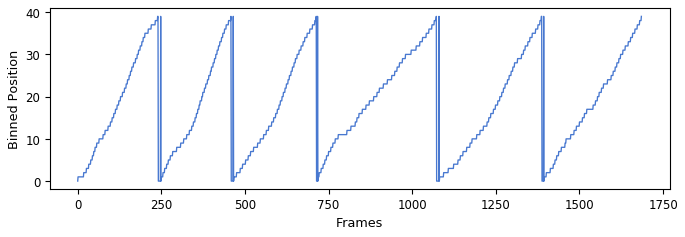

In [27]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_norew_goodlaps_eq, tracklength=tracklength, trackbins=trackbins, trackstart_index=1)
y_norew_goodlaps_eq_cat = B.position_binary

#### Run Bayes classifier on the corrected worst laps

Data shapes :  (1348, 378) (338, 378) (1348,) (338,)

Accuracy of test set:: 0.06%


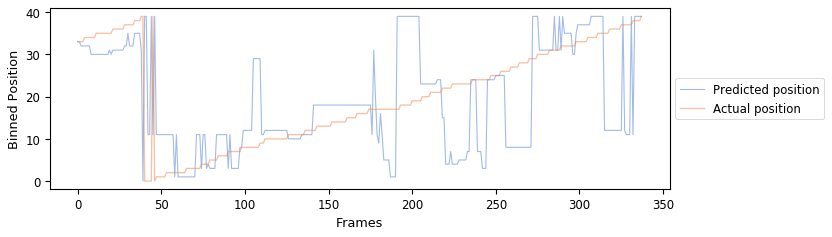

R2: 0.01
rho: 0.53




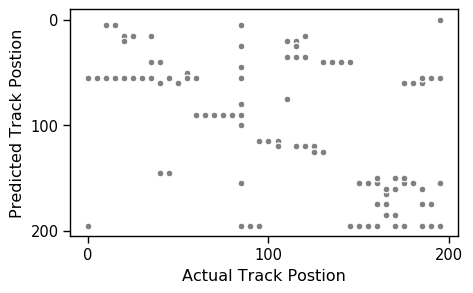

R2: 0.01
rho: 0.53




In [28]:
y_test, y_predicted = rnb.run_naivebayes(X_norew_goodlaps_eq, y_norew_goodlaps_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(1348, 378) (1348,) (338, 378) (338,)

Accuracy of test set:: 0.11%


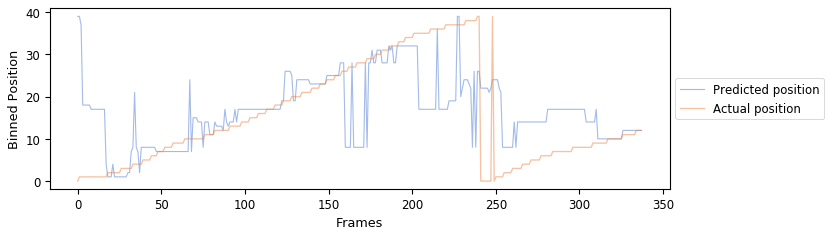

Validation 2
(1349, 378) (1349,) (337, 378) (337,)

Accuracy of test set:: 0.18%


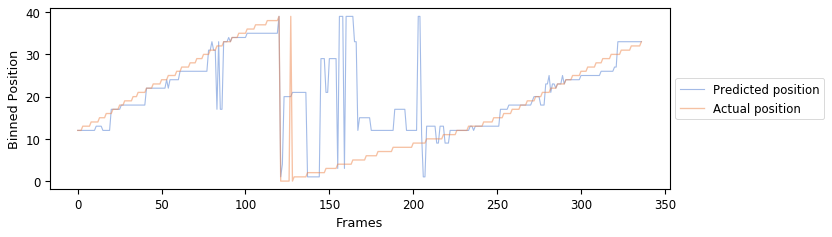

Validation 3
(1349, 378) (1349,) (337, 378) (337,)

Accuracy of test set:: 0.07%


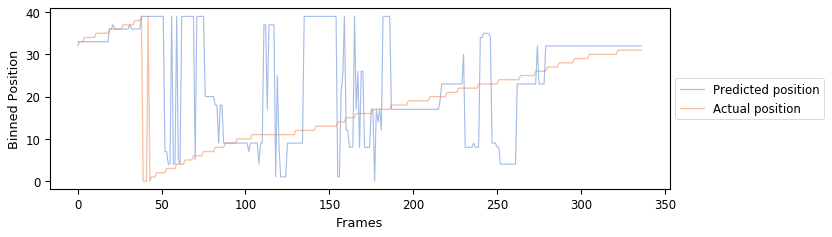

Validation 4
(1349, 378) (1349,) (337, 378) (337,)

Accuracy of test set:: 0.10%


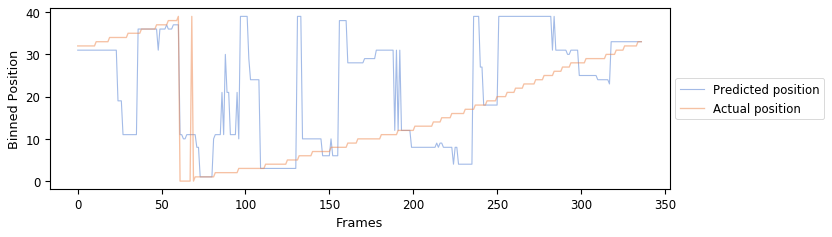

Validation 5
(1349, 378) (1349,) (337, 378) (337,)

Accuracy of test set:: 0.06%


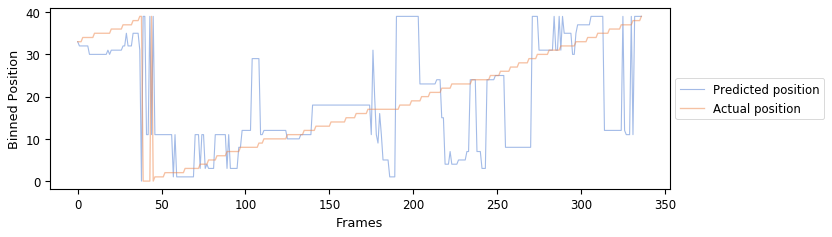

In [29]:
norewardcv_goodlaps_dataframe = rnb.k_foldvalidation(X_data=X_norew_goodlaps_eq, y_cat_data=y_norew_goodlaps_eq_cat, split_size=nsplits, figureflag=1)

In [30]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['Animal'] = animalname

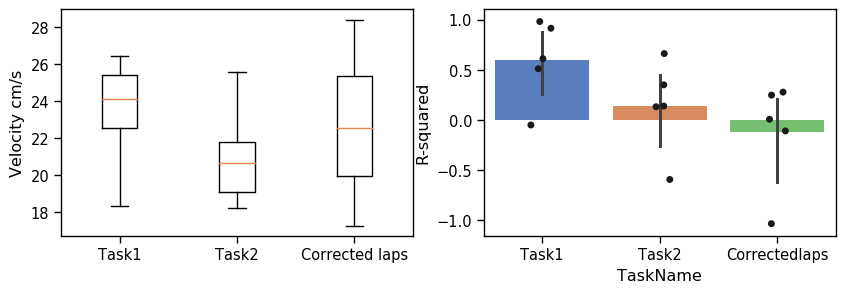

In [31]:
fs, ax1 = plt.subplots(1, 2, figsize=(10, 3), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');

### Decoding while lick is present

In [32]:
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
laptime_lick = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[:stoplicklap]

Data shapes :  (2458, 378) (2458, 1)


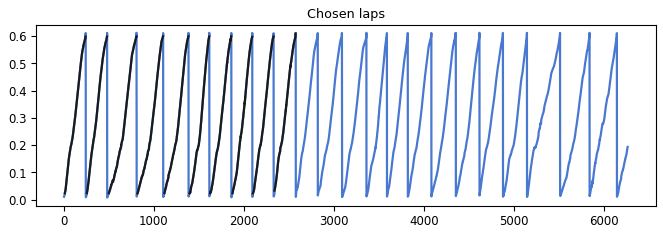

In [33]:
X_v_new_lick, Y_v_new_lick = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, thresholded_laps=np.arange(stoplicklap), E_correction=1, lapcorrectionflag=1, figureflag=1)

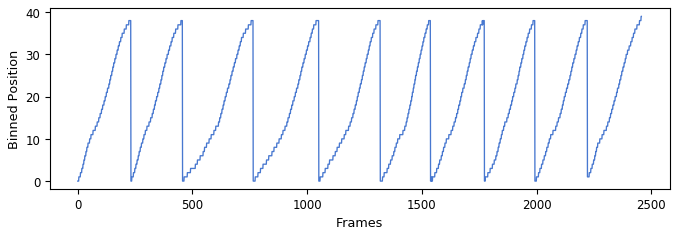

In [34]:
B = PreBeh(BehaviorData=Y_v_new_lick, tracklength=tracklength, trackbins=trackbins)
y_v_new_lick_cat = B.position_binary

Data shapes :  (1966, 378) (492, 378) (1966,) (492,)

Accuracy of test set:: 0.21%


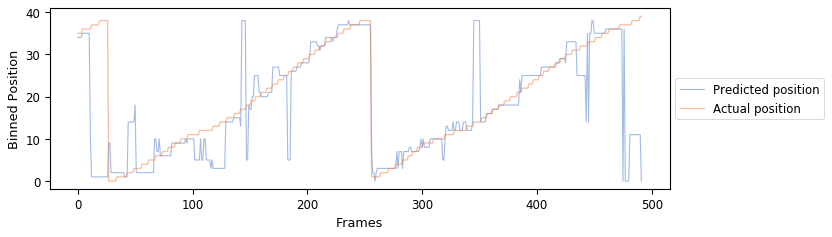

R2: 0.33
rho: 0.69




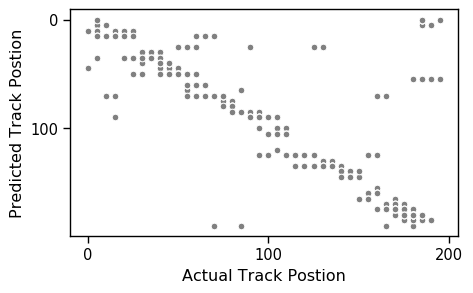

R2: 0.33
rho: 0.69




In [35]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_lick, y_v_new_lick_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(1966, 378) (1966,) (492, 378) (492,)

Accuracy of test set:: 0.32%


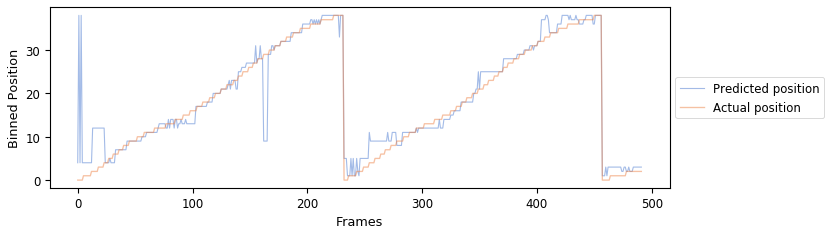

Validation 2
(1966, 378) (1966,) (492, 378) (492,)

Accuracy of test set:: 0.14%


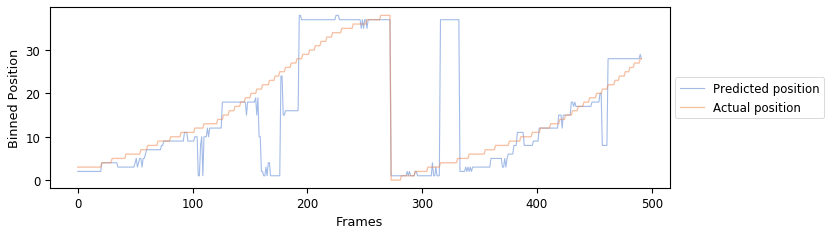

Validation 3
(1966, 378) (1966,) (492, 378) (492,)

Accuracy of test set:: 0.20%


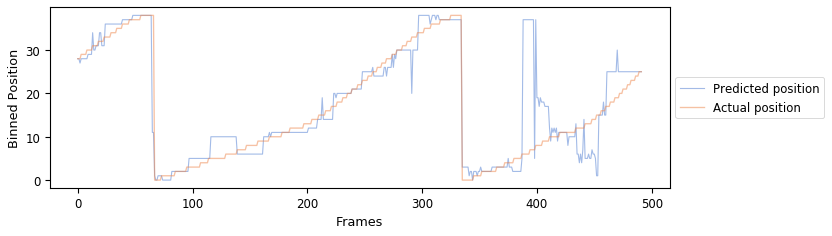

Validation 4
(1967, 378) (1967,) (491, 378) (491,)

Accuracy of test set:: 0.24%


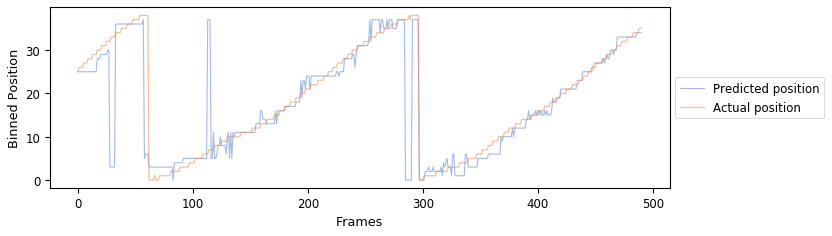

Validation 5
(1967, 378) (1967,) (491, 378) (491,)

Accuracy of test set:: 0.21%


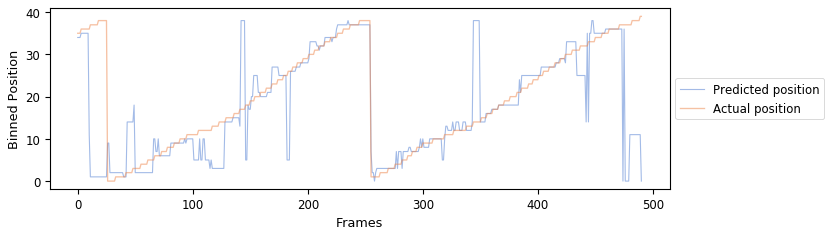

In [36]:
lickcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_lick, y_cat_data=y_v_new_lick_cat, split_size=nsplits, figureflag=1)

In [37]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2'], lickcv_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['TaskName'].iloc[nsplits*3:nsplits*4] = 'Task2_withlicks'
R2_dataframe['Animal'] = animalname

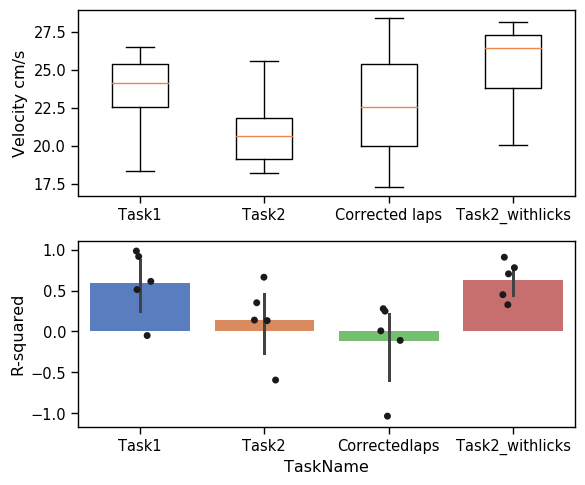

In [38]:
fs, ax1 = plt.subplots(2, 1, figsize=(6, 5), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps, tracklength/laptime_lick], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps', 'Task2_withlicks'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');
fs.tight_layout()

### Save Results 

In [39]:
#Save R-squared dataframe
R2_dataframe.to_pickle(os.path.join(SaveResults, 'velocity_comparison_R2.pkl'))